# Supervised Fine-Tuning with SFTTrainer

This notebook demonstrates how to fine-tune the `HuggingFaceTB/SmolLM2-135M` model using the `SFTTrainer` from the `trl` library. The notebook cells run and will finetune the model. You can select your difficulty by trying out different datasets.

<div style='background-color: lightblue; padding: 10px; border-radius: 5px; margin-bottom: 20px; color:black'>
    <h2 style='margin: 0;color:blue'>Exercise: Fine-Tuning SmolLM2 with SFTTrainer</h2>
    <p>Take a dataset from the Hugging Face hub and finetune a model on it. </p>
    <p><b>Difficulty Levels</b></p>
    <p>🐢 Use the `HuggingFaceTB/smoltalk` dataset</p>
    <p>🐕 Try out the `bigcode/the-stack-smol` dataset and finetune a code generation model on a specific subset `data/python`.</p>
    <p>🦁 Select a dataset that relates to a real world use case your interested in</p>
</div>

In [2]:
%%capture
!pip install torch
!pip install trl # for optimization training
!pip install peft # for creating LoRA architecture
!pip install matplotlib
!pip install -U bitsandbytes
!pip install wandb --upgrade # Explicitly install wandb

In [3]:
# Install the requirements in Google Colab
# !pip install transformers datasets trl huggingface_hub

# Authenticate to Hugging Face

from huggingface_hub import login
login()

# for convenience you can create an environment variable containing your hub token as HF_TOKEN

In [4]:
# Import necessary libraries
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from trl import  SFTConfig, SFTTrainer, setup_chat_format
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

# Load the model and tokenizer
model_name = "HuggingFaceTB/SmolLM2-135M"
model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=model_name
).to(device)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_name)

# Set up the chat format
model, tokenizer = setup_chat_format(model=model, tokenizer=tokenizer)

# Set our name for the finetune to be saved &/ uploaded to
finetune_name = "SmolLM2-FT-MyDataset"
finetune_tags = ["smol-course", "module_1"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.66k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/831 [00:00<?, ?B/s]

# Generate with the base model

Here we will try out the base model which does not have a chat template.

In [5]:
# Let's test the base model before training
prompt = "Write a haiku about programming"

# Format with template
messages = [{"role": "user", "content": prompt}]
formatted_prompt = tokenizer.apply_chat_template(messages, tokenize=False)

# Generate response
inputs = tokenizer(formatted_prompt, return_tensors="pt").to(device)
outputs = model.generate(**inputs, max_new_tokens=100)
print("Before training:")
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Before training:
user
Write a haiku about programming
Write a haiku about programming
Write a haiku about programming
Write a haiku about programming
Write a haiku about programming
Write a haiku about programming
Write a haiku about programming
Write a haiku about programming
Write a haiku about programming
Write a haiku about programming
Write a haiku about programming
Write a haiku about programming
Write a haiku about programming
Write a haiku about programming
Write a haiku about programming
Write a


In [6]:
formatted_prompt

'<|im_start|>user\nWrite a haiku about programming<|im_end|>\n'

## Dataset Preparation

We will load a sample dataset and format it for training. The dataset should be structured with input-output pairs, where each input is a prompt and the output is the expected response from the model.

**TRL will format input messages based on the model's chat templates.** They need to be represented as a list of dictionaries with the keys: `role` and `content`,.

In [7]:
# Load a sample dataset
from datasets import load_dataset

# TODO: define your dataset and config using the path and name parameters
ds = load_dataset(path="HuggingFaceTB/smoltalk", name="everyday-conversations")

README.md:   0%|          | 0.00/9.72k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


train-00000-of-00001.parquet:   0%|          | 0.00/946k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


test-00000-of-00001.parquet:   0%|          | 0.00/52.6k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2260 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/119 [00:00<?, ? examples/s]

In [ ]:
# TODO: 🦁 If your dataset is not in a format that TRL can convert to the chat template, you will need to process it. Refer to the [module](../chat_templates.md)

In [8]:
ds

DatasetDict({
    train: Dataset({
        features: ['full_topic', 'messages'],
        num_rows: 2260
    })
    test: Dataset({
        features: ['full_topic', 'messages'],
        num_rows: 119
    })
})

In [9]:
ds['train'][0]['messages']

[{'content': 'Hi there', 'role': 'user'},
 {'content': 'Hello! How can I help you today?', 'role': 'assistant'},
 {'content': "I'm looking for a beach resort for my next vacation. Can you recommend some popular ones?",
  'role': 'user'},
 {'content': "Some popular beach resorts include Maui in Hawaii, the Maldives, and the Bahamas. They're known for their beautiful beaches and crystal-clear waters.",
  'role': 'assistant'},
 {'content': 'That sounds great. Are there any resorts in the Caribbean that are good for families?',
  'role': 'user'},
 {'content': 'Yes, the Turks and Caicos Islands and Barbados are excellent choices for family-friendly resorts in the Caribbean. They offer a range of activities and amenities suitable for all ages.',
  'role': 'assistant'},
 {'content': "Okay, I'll look into those. Thanks for the recommendations!",
  'role': 'user'},
 {'content': "You're welcome. I hope you find the perfect resort for your vacation.",
  'role': 'assistant'}]

## Configuring the SFTTrainer

The `SFTTrainer` is configured with various parameters that control the training process. These include the number of training steps, batch size, learning rate, and evaluation strategy. Adjust these parameters based on your specific requirements and computational resources.

In [10]:
# Configure the SFTTrainer
sft_config = SFTConfig(
    output_dir="./sft_output",
    max_steps=1000,  # Adjust based on dataset size and desired training duration
    per_device_train_batch_size=4,  # Set according to your GPU memory capacity
    learning_rate=5e-5,  # Common starting point for fine-tuning
    logging_steps=10,  # Frequency of logging training metrics
    save_steps=100,  # Frequency of saving model checkpoints
    #evaluation_strategy="steps",  # Evaluate the model at regular intervals
    eval_steps=50,  # Frequency of evaluation
    use_mps_device=(
        True if device == "mps" else False
    ),  # Use MPS for mixed precision training
    hub_model_id=finetune_name,  # Set a unique name for your model
)

# Initialize the SFTTrainer
trainer = SFTTrainer(
    model=model,
    args=sft_config,
    train_dataset=ds["train"],
    processing_class=tokenizer,
    eval_dataset=ds["test"],
)

# TODO: 🦁 🐕 align the SFTTrainer params with your chosen dataset. For example, if you are using the `bigcode/the-stack-smol` dataset, you will need to choose the `content` column`

Converting train dataset to ChatML:   0%|          | 0/2260 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/2260 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/2260 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/2260 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/119 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/119 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/119 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/119 [00:00<?, ? examples/s]

## Training the Model

With the trainer configured, we can now proceed to train the model. The training process will involve iterating over the dataset, computing the loss, and updating the model's parameters to minimize this loss.

In [11]:
# Train the model
trainer.train()

# Save the model
trainer.save_model(f"./{finetune_name}")

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: b-nunes-bruno (b-nunes-bruno-universidad-aut-noma-de-madrid) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
10,1.959100
20,1.417500
30,1.306400
40,1.212000
50,1.105600
60,1.179200
70,1.181200
80,1.132300
90,1.085800
100,1.104700


In [ ]:
trainer.push_to_hub(tags=finetune_tags)

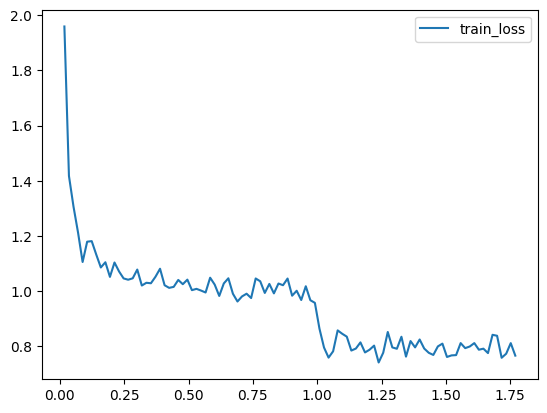

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Retrieve log_history and save it to a dataframe
log = pd.DataFrame(trainer.state.log_history)
log_t = log[log['loss'].notna()]
#log_e = log[log['eval_loss'].notna()]

# Plot train and evaluation losses
plt.plot(log_t["epoch"], log_t["loss"], label = "train_loss")
#plt.plot(log_e["epoch"], log_e["eval_loss"], label = "eval_loss")
plt.legend()
plt.show()

<div style='background-color: lightblue; padding: 10px; border-radius: 5px; margin-bottom: 20px; color:black'>
    <h2 style='margin: 0;color:blue'>Bonus Exercise: Generate with fine-tuned model</h2>
    <p>🐕 Use the fine-tuned to model generate a response, just like with the base example..</p>
</div>

In [16]:
# Test the fine-tuned model on the same prompt

# Let's test the base model before training
prompt = "Write a haiku about programming"

# Format with template
messages = [{"role": "user", "content": prompt}]
formatted_prompt = tokenizer.apply_chat_template(messages, tokenize=False)

# Generate response
inputs = tokenizer(formatted_prompt, return_tensors="pt").to(device)

# TODO: use the fine-tuned to model generate a response, just like with the base example.

In [24]:
model_FT = AutoModelForCausalLM.from_pretrained(f"./{finetune_name}").to(device)

output = model_FT.generate(**inputs, max_new_tokens=100)

output[0]

tensor([    1,  4093,   198, 19161,   253,   421, 30614,   563,  6256,     2,
          198,     2], device='cuda:0')

In [23]:
tokenizer.decode(output[0], skip_special_tokens=True)

'user\nWrite a haiku about programming\n'

## 💐 You're done!

This notebook provided a step-by-step guide to fine-tuning the `HuggingFaceTB/SmolLM2-135M` model using the `SFTTrainer`. By following these steps, you can adapt the model to perform specific tasks more effectively. If you want to carry on working on this course, here are steps you could try out:

- Try this notebook on a harder difficulty
- Review a colleagues PR
- Improve the course material via an Issue or PR.